# California Price Prediction

## Downloading the dataset

In [76]:
import pandas as pd 
import numpy as np

In [77]:
housing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   longitude                20640 non-null  float64
 1   latitude                 20640 non-null  float64
 2   housing_median_age       20640 non-null  float64
 3   total_rooms              20640 non-null  float64
 4   total_bedrooms           20433 non-null  float64
 5   population               20640 non-null  float64
 6   households               20640 non-null  float64
 7   median_income            20640 non-null  float64
 8   median_house_value       20640 non-null  float64
 9   ocean_proximity          20640 non-null  object 
 10  rooms_per_household      20640 non-null  float64
 11  bedrooms_per_households  20433 non-null  float64
dtypes: float64(11), object(1)
memory usage: 1.9+ MB


We can see that the `total_bedrooms` field contains missing values and hence we need to fill them up 

And also here `median_house_value` is the dependent variable(target column) and others are independent variable(input column)

In [78]:
housing_df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_household,bedrooms_per_households
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909,5.429000,1.097062
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874,2.474173,0.476104
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000,0.846154,0.333333
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000,4.440716,1.006029
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000,5.229129,1.048889
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000,6.052381,1.099631
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000,141.909091,34.066667


## EDA

In [79]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns 
import plotly.express as px

matplotlib.rcParams['figure.figsize'] = 10,10
sns.set_style('darkgrid')


In [80]:
housing_df.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity', 'rooms_per_household',
       'bedrooms_per_households'],
      dtype='object')

In [81]:
px.histogram(housing_df,y='total_rooms',x='median_house_value')

We can see that as the total number of rooms increases, the price also increases

Text(0.5, 1.0, 'Median age of housing')

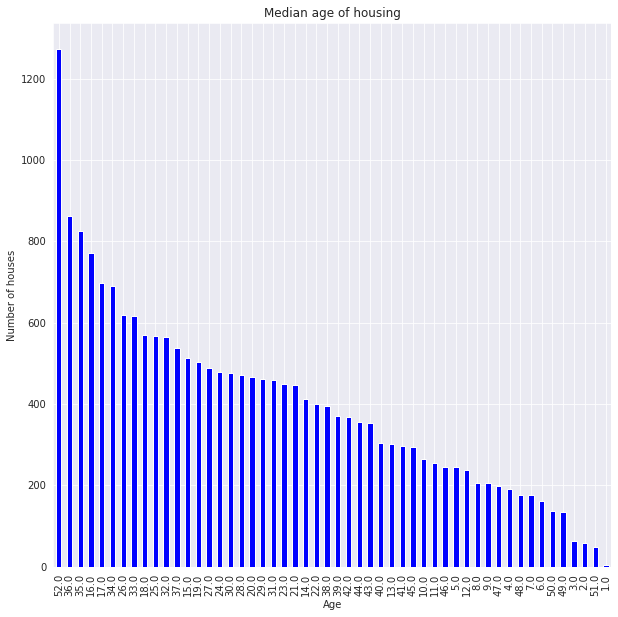

In [82]:
housing_df.housing_median_age.value_counts().plot(kind='bar',color='blue')
plt.xlabel('Age')
plt.ylabel('Number of houses')
plt.title('Median age of housing')

Maximum of house are 52 years old (about 1500 houses)

In [83]:
px.histogram(housing_df,x='median_house_value',y='total_rooms')

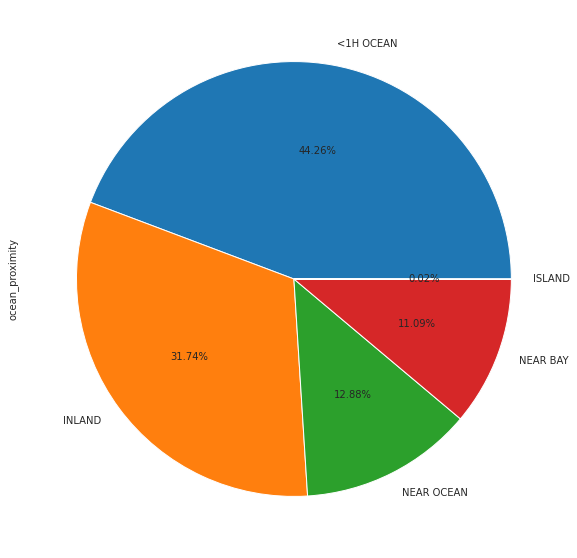

In [84]:
housing_df.ocean_proximity.value_counts().plot(kind='pie',autopct='%.2f%%')

We can see that most of the houses are less than 1 proximity from th ocean and houses in the island are lesser

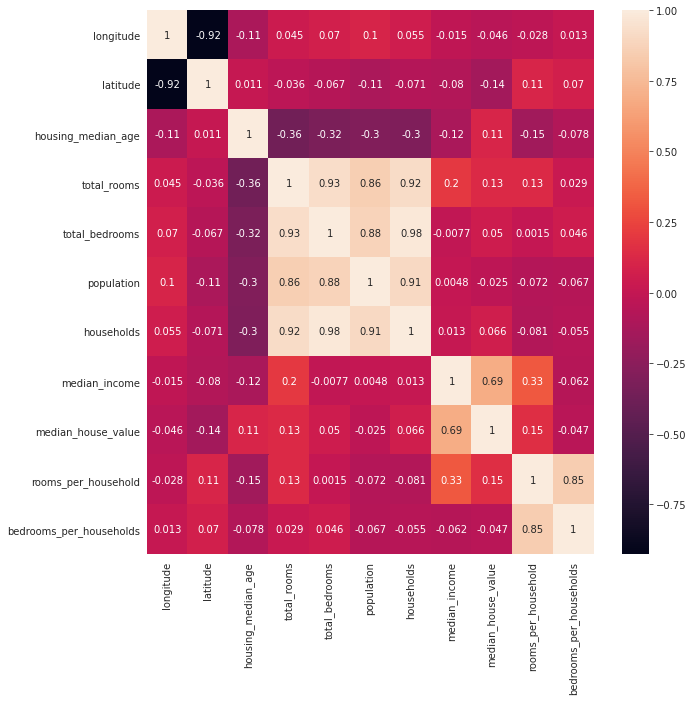

In [85]:
sns.heatmap(housing_df.corr(),annot=True)

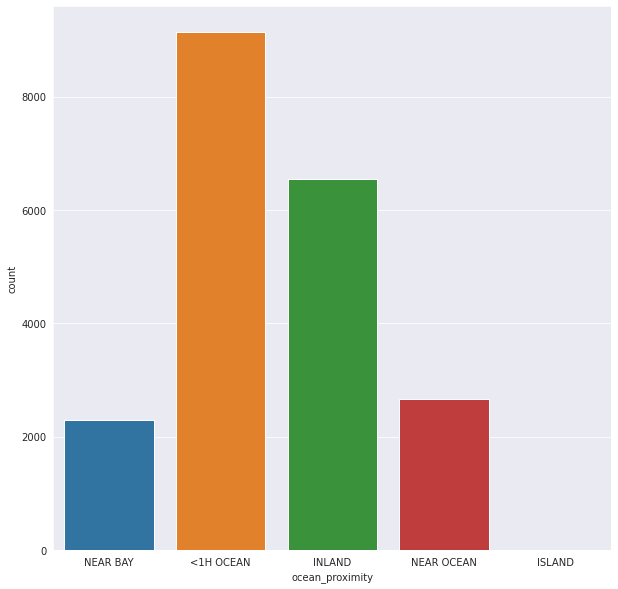

In [86]:
sns.countplot(data=housing_df,x='ocean_proximity')

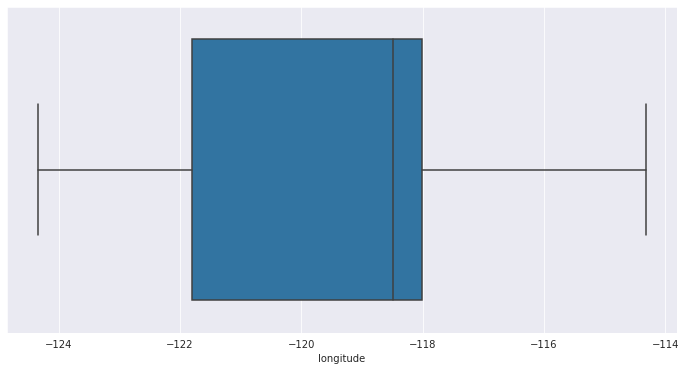

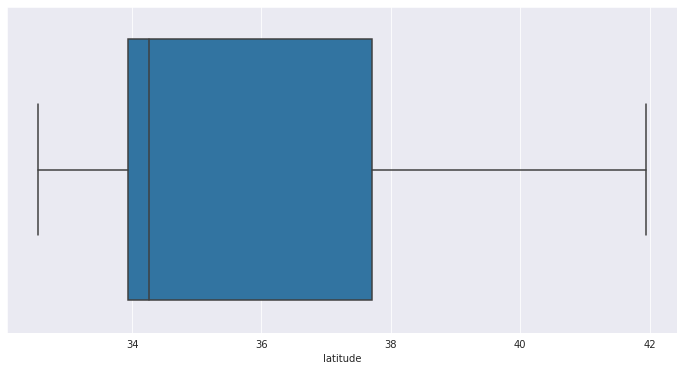

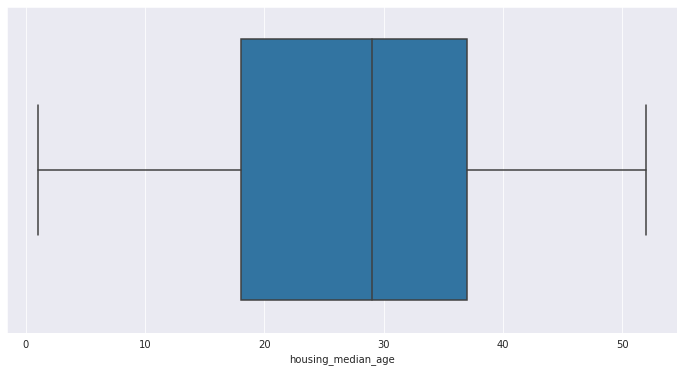

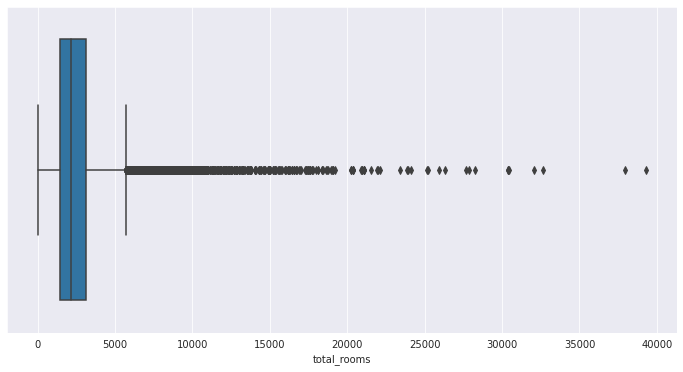

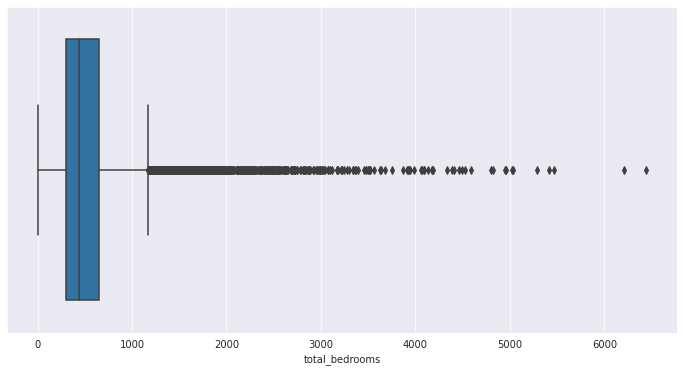

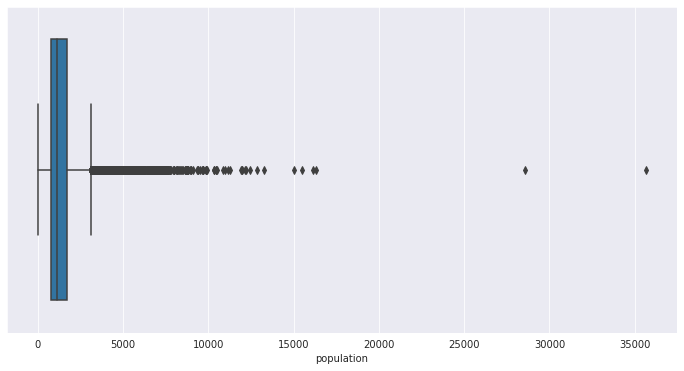

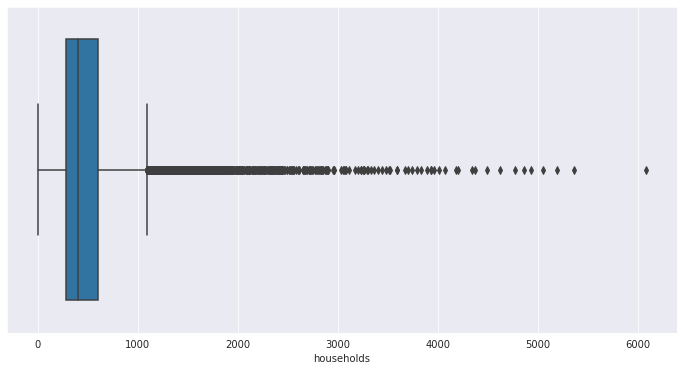

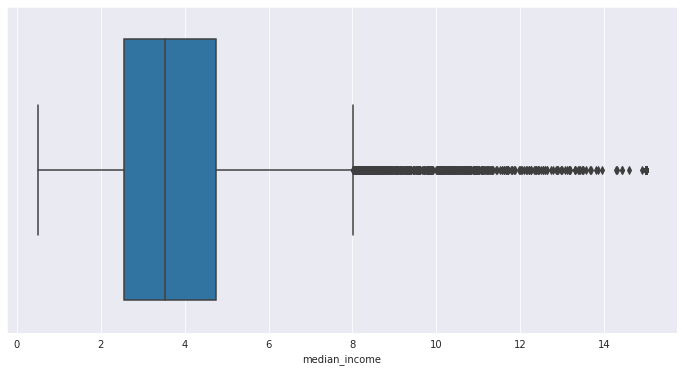

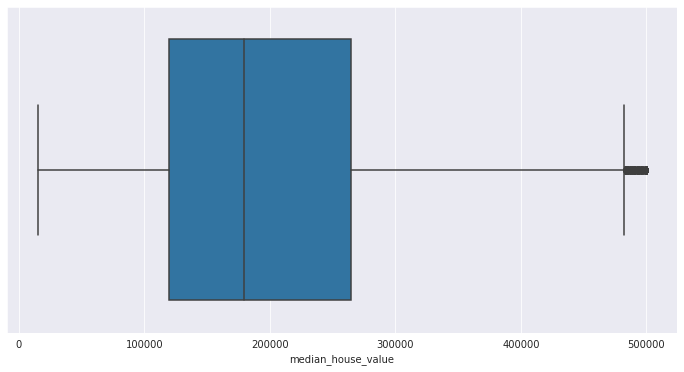

In [93]:
for i in ['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value']:
    fig, ax = plt.subplots()
    fig.set_size_inches(12,6)
    #plt.xlim(-10,10)
    sns.boxplot(x=i,data=housing_df,ax=ax)

We can see a lot of outliers present in `total_rooms`,`total_bedrooms`,`population`,`households`,etc. Lets remove them

In [98]:
def outliers(df,fl):
  q1 = df[fl].quantile(0.25)
  q3 = df[fl].quantile(0.75)
  IQR = q3-q1
  lower_bound = q1 - 1.5*IQR
  upper_bound = q3 + 1.5*IQR
  ls = df.index[ (df[fl]<lower_bound) | (df[fl]>upper_bound)]
  return ls

In [101]:
index_list = []
for x in ['total_rooms', 'total_bedrooms', 'population', 'households', 'median_income','median_house_value']:
         index_list.extend(outliers(housing_df,x))

Now let's drop the outliers from the data set

In [102]:
def remove(df,ls):
  ls = sorted(set(index_list))
  df = df.drop(ls)
  return df

In [ ]:
housing_df = remove(housing_df,index_list)

### Pre processing

In [108]:
housing_df['rooms_per_household'] = housing_df['total_rooms']/housing_df['households']
housing_df['bedrooms_per_households'] = housing_df['total_bedrooms']/housing_df['households']

In [109]:
housing_df.head(1)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,rooms_per_household,bedrooms_per_households
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,8.288136,1.073446


#### Input and target columns

In [110]:
housing_df.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity', 'rooms_per_household',
       'bedrooms_per_households'],
      dtype='object')

In [111]:
input_col = ['longitude','latitude','housing_median_age','total_rooms','total_bedrooms','population','households','median_income','ocean_proximity']
target_col = 'median_house_value'

In [112]:
inputs = housing_df[input_col].copy()
targets = housing_df[target_col].copy()

In [113]:
numeric_col = inputs.select_dtypes(np.number).columns.tolist()
cate_col = inputs.select_dtypes('object').columns.tolist()
print(numeric_col)
print(cate_col)

['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income']
['ocean_proximity']


#### Imputing missing values

In [114]:
inputs[numeric_col].isna().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        175
population              0
households              0
median_income           0
dtype: int64

In [115]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer().fit(inputs[numeric_col])

In [116]:
inputs[numeric_col] = imputer.transform(inputs[numeric_col])

#### Encoding Cateogrical Columns

In [118]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse=False,handle_unknown='ignore').fit(inputs[cate_col])

In [119]:
enc_col = list(encoder.get_feature_names(cate_col))
enc_col = ['ocean_proximity_ OCEAN', 'ocean_proximity_INLAND', 'ocean_proximity_ISLAND', 'ocean_proximity_NEAR BAY', 'ocean_proximity_NEAR OCEAN']

In [120]:
inputs[enc_col] = encoder.transform(inputs[cate_col])

In [121]:
x = inputs[numeric_col+enc_col]
x

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity_ OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,0.0,0.0,0.0,1.0,0.0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,0.0,0.0,0.0,1.0,0.0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,0.0,0.0,0.0,1.0,0.0
5,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,0.0,0.0,0.0,1.0,0.0
6,-122.25,37.84,52.0,2535.0,489.0,1094.0,514.0,3.6591,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,0.0,1.0,0.0,0.0,0.0
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,0.0,1.0,0.0,0.0,0.0
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,0.0,1.0,0.0,0.0,0.0
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,0.0,1.0,0.0,0.0,0.0


### Model

Since here we are dealing with problem based on Regression, let's use the XGBoost model

In [122]:
from xgboost import XGBRegressor

In [123]:
model = XGBRegressor(random_state=42,n_jobs=-1).fit(x,targets)

[06:27:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [124]:
model.predict(x)

array([339546.84, 297336.1 , 246341.6 , ...,  79450.46,  81071.76,
        87918.28], dtype=float32)

In [125]:
from sklearn.metrics import mean_squared_error
mean_squared_error(model.predict(x),targets,squared=False)

47816.649399268914

#### Feature importance

In [126]:
importance_df = pd.DataFrame({
    'Feature':numeric_col+enc_col,
    'Importance':model.feature_importances_
}).sort_values('Importance',ascending=False)

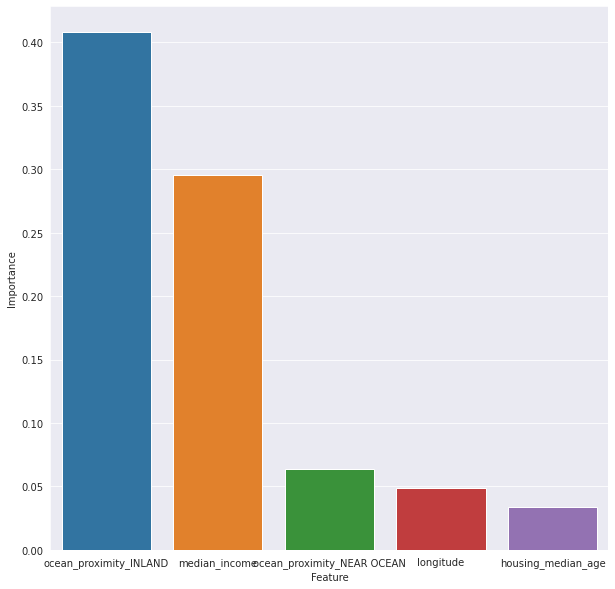

In [127]:
sns.barplot(data=importance_df.head(),x='Feature',y='Importance')

We can see that the model has lot error in predicting the sales. So let's hypertune the model

#### Hypertuning

##### max_depth

In [128]:
model = XGBRegressor(random_state=42,n_jobs=-1,max_depth=2).fit(x,targets)
mean_squared_error(model.predict(x),targets,squared=False)

[06:27:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


52383.95664089339

In [129]:
model = XGBRegressor(random_state=42,n_jobs=-1,max_depth=5).fit(x,targets)
mean_squared_error(model.predict(x),targets,squared=False)

[06:27:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


38640.211911978295

In [130]:
model = XGBRegressor(random_state=42,n_jobs=-1,max_depth=10).fit(x,targets)
mean_squared_error(model.predict(x),targets,squared=False)

[06:27:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


16724.540773071243

In [131]:
model = XGBRegressor(random_state=42,n_jobs=-1,max_depth=15).fit(x,targets)
mean_squared_error(model.predict(x),targets,squared=False)

[06:27:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


2858.100875658473

In [132]:
model = XGBRegressor(random_state=42,n_jobs=-1,max_depth=20).fit(x,targets)
mean_squared_error(model.predict(x),targets,squared=False)

[06:27:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


385.98567940716265

In [133]:
model = XGBRegressor(random_state=42,n_jobs=-1,max_depth=30).fit(x,targets)
mean_squared_error(model.predict(x),targets,squared=False)

[06:27:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


185.76150162526127

In [134]:
model = XGBRegressor(random_state=42,n_jobs=-1,max_depth=40).fit(x,targets)
mean_squared_error(model.predict(x),targets,squared=False)

[06:28:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


183.30721515198348

In [135]:
model = XGBRegressor(random_state=42,n_jobs=-1,max_depth=50).fit(x,targets)
mean_squared_error(model.predict(x),targets,squared=False)

[06:28:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


183.1302918396887

In [136]:
def test_params(**params):
    model = XGBRegressor(random_state=42, n_jobs=-1, **params).fit(x,targets)
    train_rmse = mean_squared_error(model.predict(x),targets, squared=False)
    return train_rmse

In [139]:
def test_param_and_plot(param_name, param_values):
    train_errors= []
    for value in param_values:
        params = {param_name: value}
        train_rmse = test_params(**params)
        train_errors.append(train_rmse)
    plt.figure(figsize=(10,6))
    plt.title('Overfitting curve: ' + param_name)
    plt.plot(param_values, train_errors, 'b-o')
    plt.xlabel(param_name)
    plt.ylabel('RMSE')

[06:32:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:32:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:32:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:32:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:32:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:33:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:33:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:33:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

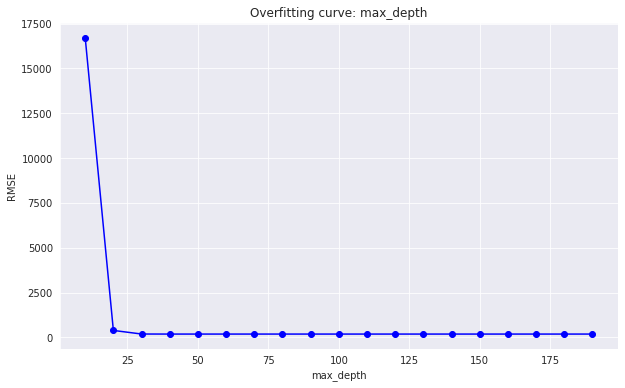

In [140]:
test_param_and_plot('max_depth',[x for x in range(10,200,10)])

We can see the error has reduced to 207(`max_depth`=40) and started increasing.

##### n_estimators

In [41]:
model = XGBRegressor(random_state=42,n_jobs=-1,max_depth=40,n_estimators=10).fit(x,targets)
mean_squared_error(model.predict(x),targets,squared=False)

[04:21:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


92127.2728696477

In [42]:
model = XGBRegressor(random_state=42,n_jobs=-1,max_depth=40,n_estimators=20).fit(x,targets)
mean_squared_error(model.predict(x),targets,squared=False)

[04:21:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


39391.863680679206

In [43]:
model = XGBRegressor(random_state=42,n_jobs=-1,max_depth=40,n_estimators=50).fit(x,targets)
mean_squared_error(model.predict(x),targets,squared=False)

[04:21:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


4352.064035634274

In [44]:
model = XGBRegressor(random_state=42,n_jobs=-1,max_depth=40,n_estimators=70).fit(x,targets)
mean_squared_error(model.predict(x),targets,squared=False)

[04:21:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


1211.5772067485839

In [45]:
model = XGBRegressor(random_state=42,n_jobs=-1,max_depth=40,n_estimators=100).fit(x,targets)
mean_squared_error(model.predict(x),targets,squared=False)

[04:22:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


209.20525067170405

In [46]:
model = XGBRegressor(random_state=42,n_jobs=-1,max_depth=40,n_estimators=150).fit(x,targets)
mean_squared_error(model.predict(x),targets,squared=False)

[04:22:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


13.357289577209949

In [47]:
model = XGBRegressor(random_state=42,n_jobs=-1,max_depth=40,n_estimators=200).fit(x,targets)
mean_squared_error(model.predict(x),targets,squared=False)

[04:22:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


0.9249434680785193

[06:37:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:37:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:37:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:37:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:37:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:37:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:37:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:37:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

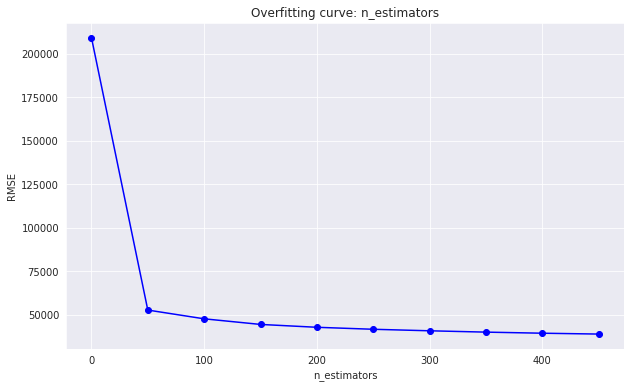

In [142]:
test_param_and_plot('n_estimators',[x for x in range(0,500,50)])

We can see that the error has reduce to less than 1 which is pretty good

##### learning_rate

In [48]:
model = XGBRegressor(random_state=42,n_jobs=-1,max_depth=40,n_estimators=200,learning_rate=0.01).fit(x,targets)
mean_squared_error(model.predict(x),targets,squared=False)

[04:23:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


42027.4536131987

In [49]:
model = XGBRegressor(random_state=42,n_jobs=-1,max_depth=40,n_estimators=200,learning_rate=0.1).fit(x,targets)
mean_squared_error(model.predict(x),targets,squared=False)

[04:23:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


0.9249434680785193

In [50]:
model = XGBRegressor(random_state=42,n_jobs=-1,max_depth=40,n_estimators=200,learning_rate=0.3).fit(x,targets)
mean_squared_error(model.predict(x),targets,squared=False)

[04:24:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


0.020936766107000786

##### booster

In [51]:
model = XGBRegressor(random_state=42,n_jobs=-1,max_depth=40,n_estimators=200,learning_rate=0.1,booster='gblinear').fit(x,targets)
mean_squared_error(model.predict(x),targets,squared=False)

[04:24:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


77389.80321600623

Seems like a linear model is not suited for this dataset

In [52]:
model = XGBRegressor(random_state=42,n_jobs=-1,max_depth=40,n_estimators=200,learning_rate=0.1,booster='gbtree').fit(x,targets)
mean_squared_error(model.predict(x),targets,squared=False)

[04:24:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


0.9249434680785193

Seems like tree model is doing good with this dataset

In [53]:
model = XGBRegressor(random_state=42,n_jobs=-1,max_depth=40,n_estimators=200,learning_rate=0.1,booster='dart').fit(x,targets)
mean_squared_error(model.predict(x),targets,squared=False)

[04:25:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


0.928606024554199

### Putting it together and making predictions

In [55]:
model = XGBRegressor(random_state=42,n_jobs=-1,max_depth=40,n_estimators=200,learning_rate=0.1,booster='gbtree').fit(x,targets)
model.fit(x,targets)

[04:30:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:31:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=40, min_child_weight=1, missing=None, n_estimators=200,
             n_jobs=-1, nthread=None, objective='reg:linear', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [57]:
mean_squared_error(model.predict(x),targets)

0.8555204191411189

In [67]:
model.predict(x)

array([452599.88, 358499.88, 352100.3 , ...,  92299.98,  84699.97,
        89399.97], dtype=float32)

In [68]:
targets

0        452600.0
1        358500.0
2        352100.0
3        341300.0
4        342200.0
           ...   
20635     78100.0
20636     77100.0
20637     92300.0
20638     84700.0
20639     89400.0
Name: median_house_value, Length: 20640, dtype: float64

Now lets pass in single values as inputs and lets make the model to predict the housing value

In [64]:
type(x)

pandas.core.frame.DataFrame

In [66]:
single_input = pd.DataFrame([{
    'longitude':100,
    'latitude':35,
    'housing_median_age':50,
    'total_rooms':1000,
    'total_bedrooms':500,
    'population':2000,
    'households':200,
    'median_income':10,
    'ocean_proximity_ OCEAN':0.0,
    'ocean_proximity_INLAND':1.0,
    'ocean_proximity_ISLAND':0.0,
    'ocean_proximity_NEAR BAY':0.0,
    'ocean_proximity_NEAR OCEAN':0.0}])
model.predict(single_input)

array([403171.], dtype=float32)

It seems like for the given set of inputs for the fields, the model predict the median_house_price as $403171